In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import tensorflow as tf
from sklearn.metrics import f1_score 
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Flatten, MaxPooling2D, Dropout, Conv2D
from PIL import Image
import os

In [2]:
plate_cascade = cv2.CascadeClassifier('indian_license_plate.xml')

In [3]:
def detect_plate(img, text=''):
    plate_img = img.copy()
    roi = img.copy()
    plate_rect = plate_cascade.detectMultiScale(plate_img, scaleFactor=1.2, minNeighbors=7)

    plate = None
    max_plate_area = 0  # Initialize maximum plate area variable before the loop

    for (x, y, w, h) in plate_rect:
        roi_ = roi[y:y+h, x:x+w, :]
        plate_area = w * h

        # Check if the current plate has a larger area than the previous maximum
        if plate_area > max_plate_area:
            max_plate_area = plate_area
            plate = roi[y:y+h, x:x+w, :]
            cv2.rectangle(plate_img, (x+2, y), (x+w-3, y+h-5), (51, 181, 155), 3)

    if text != '' and plate is not None:
        plate_img = cv2.putText(plate_img, text, (x-w//2, y-h//2),
                                cv2.FONT_HERSHEY_COMPLEX_SMALL, 0.5, (51, 181, 155), 1, cv2.LINE_AA)

    return plate_img, plate


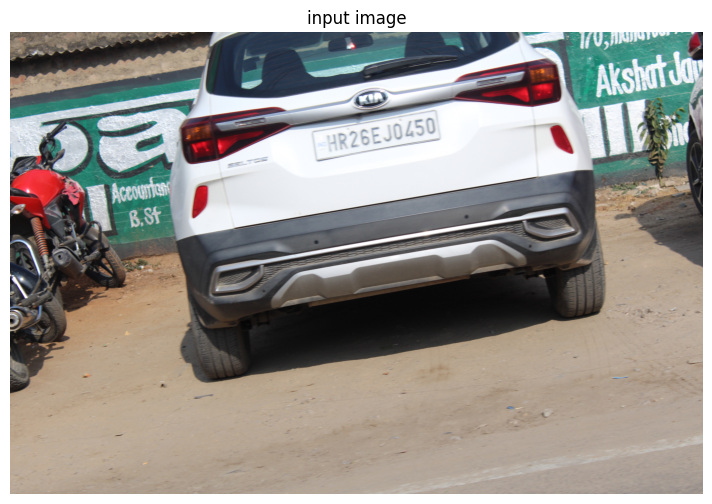

In [9]:
def display(img_, title=''):
    # Check if the image is empty
    if img_ is None or img_.size == 0:
        raise ValueError("Error: Image is empty.")
    
    # Convert BGR to RGB (OpenCV uses BGR by default)
    img = cv2.cvtColor(img_, cv2.COLOR_BGR2RGB)

    # Display the image using matplotlib
    fig = plt.figure(figsize=(10, 6))
    ax = plt.subplot(111)
    ax.imshow(img)
    plt.axis('off')
    plt.title(title)
    plt.show()


img = cv2.imread('sendjoshi/117.jpg')
display(img, 'input image')


In [10]:
# def add_salt_and_pepper_noise(image, salt_prob=0.1, pepper_prob=0.1):
#     noisy_image = np.copy(image)

#     # Add salt noise
#     salt_pixels = np.random.rand(*image.shape[:2]) < salt_prob
#     noisy_image[salt_pixels, :] = 255

#     # Add pepper noise
#     pepper_pixels = np.random.rand(*image.shape[:2]) < pepper_prob
#     noisy_image[pepper_pixels, :] = 0

#     return noisy_image

def remove_salt_and_pepper_noise(noisy_image, kernel_size=3):
    # Use a median filter to remove salt and pepper noise
    denoised_image = cv2.medianBlur(noisy_image, ksize=kernel_size)

    return denoised_image

# # Provide the image path directly
# image_path = "images/339.jpg"

# # Read the original image
# original_image = cv2.imread(image_path)

# # Add more salt and pepper noise to the image
# noisy_image = add_salt_and_pepper_noise(original_image, salt_prob=0.2, pepper_prob=0.2)

# destination_folder = 'Hazy_Images'

# # Ensure the destination folder exists, create if not
# os.makedirs(destination_folder, exist_ok=True)

# # Specify the complete path including filename and extension
# destination_path = os.path.join(destination_folder, '18.jpg')

# # Save the image
# cv2.imwrite(destination_path, noisy_image)

# # Display the noisy image
# plt.subplot(1, 3, 1)
# plt.imshow(cv2.cvtColor(noisy_image, cv2.COLOR_BGR2RGB))
# plt.title("Noisy Image")

# # Remove salt and pepper noise
denoised_image = remove_salt_and_pepper_noise(img)

# # Display the denoised image
# plt.subplot(1, 3, 2)
# plt.imshow(cv2.cvtColor(denoised_image, cv2.COLOR_BGR2RGB))
# plt.title("Denoised Image")

# # Display the original image for comparison
# plt.subplot(1, 3, 3)
# plt.imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))
# plt.title("Original Image")

# img = denoised_image
# plt.show()


In [11]:
# Getting plate prom the processed image
# img = denoised_image
output_img, plate = detect_plate(img)

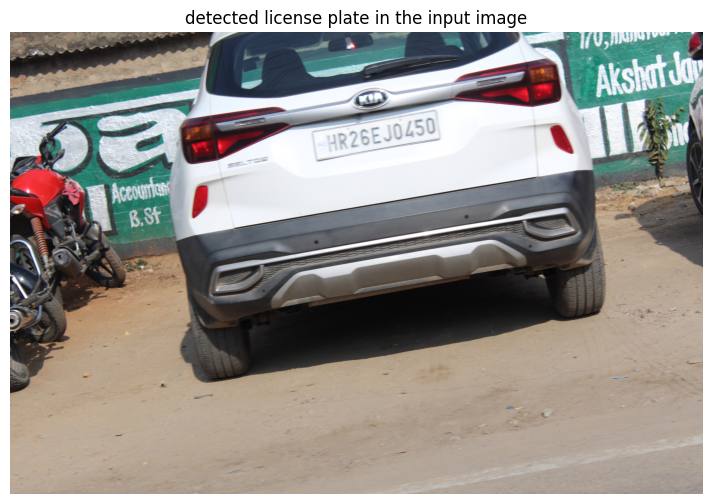

In [12]:
display(output_img, 'detected license plate in the input image')

In [13]:
display(plate, 'extracted license plate from the image')

ValueError: Error: Image is empty.

In [28]:
# Match contours to license plate or character template
def find_contours(dimensions, img) :

    # Find all contours in the image
    cntrs, _ = cv2.findContours(img.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # Retrieve potential dimensions
    lower_width = dimensions[0]
    upper_width = dimensions[1]
    lower_height = dimensions[2]
    upper_height = dimensions[3]
    
    # Check largest 5 or  15 contours for license plate or character respectively
    cntrs = sorted(cntrs, key=cv2.contourArea, reverse=True)[:15]
    
    ii = cv2.imread('contour.jpg')
    
    x_cntr_list = []
    target_contours = []
    img_res = []
    for cntr in cntrs :
        # detects contour in binary image and returns the coordinates of rectangle enclosing it
        intX, intY, intWidth, intHeight = cv2.boundingRect(cntr)
        
        # checking the dimensions of the contour to filter out the characters by contour's size
        if intWidth > lower_width and intWidth < upper_width and intHeight > lower_height and intHeight < upper_height :
            x_cntr_list.append(intX) #stores the x coordinate of the character's contour, to used later for indexing the contours

            char_copy = np.zeros((44,24))
            # extracting each character using the enclosing rectangle's coordinates.
            char = img[intY:intY+intHeight, intX:intX+intWidth]
            char = cv2.resize(char, (20, 40))
            
            cv2.rectangle(ii, (intX,intY), (intWidth+intX, intY+intHeight), (50,21,200), 2)
            plt.imshow(ii, cmap='gray')

            # Make result formatted for classification: invert colors
            char = cv2.subtract(255, char)

            # Resize the image to 24x44 with black border
            char_copy[2:42, 2:22] = char
            char_copy[0:2, :] = 0
            char_copy[:, 0:2] = 0
            char_copy[42:44, :] = 0
            char_copy[:, 22:24] = 0

            img_res.append(char_copy) # List that stores the character's binary image (unsorted)
            
    # Return characters on ascending order with respect to the x-coordinate (most-left character first)
            
    plt.show()
    # arbitrary function that stores sorted list of character indeces
    indices = sorted(range(len(x_cntr_list)), key=lambda k: x_cntr_list[k])
    img_res_copy = []
    for idx in indices:
        img_res_copy.append(img_res[idx])# stores character images according to their index
    img_res = np.array(img_res_copy)

    return img_res

In [29]:
# Find characters in the resulting images
def segment_characters(image) :

    # Preprocess cropped license plate image
    img_lp = cv2.resize(image, (333, 75))
    img_gray_lp = cv2.cvtColor(img_lp, cv2.COLOR_BGR2GRAY)
    _, img_binary_lp = cv2.threshold(img_gray_lp, 200, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    img_binary_lp = cv2.erode(img_binary_lp, (3,3))
    img_binary_lp = cv2.dilate(img_binary_lp, (3,3))

    LP_WIDTH = img_binary_lp.shape[0]
    LP_HEIGHT = img_binary_lp.shape[1]

    # Make borders white
    img_binary_lp[0:3,:] = 255
    img_binary_lp[:,0:3] = 255
    img_binary_lp[72:75,:] = 255
    img_binary_lp[:,330:333] = 255

    # Estimations of character contours sizes of cropped license plates
    dimensions = [LP_WIDTH/6,
                       LP_WIDTH/2,
                       LP_HEIGHT/10,
                       2*LP_HEIGHT/3]
    plt.imshow(img_binary_lp, cmap='gray')
    plt.show()
    cv2.imwrite('contour.jpg',img_binary_lp)

    # Get contours within cropped license plate
    char_list = find_contours(dimensions, img_binary_lp)

    return char_list

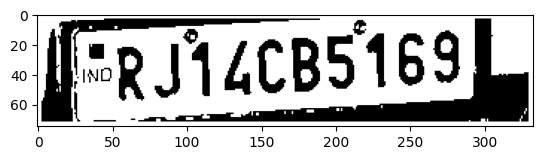

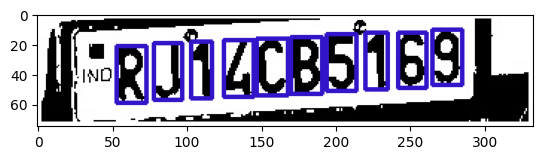

In [38]:
# Let's see the segmented characters
char = segment_characters(plate)

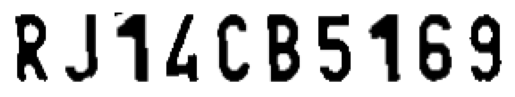

In [39]:
for i in range(len(char)):
    plt.subplot(1, 10, i+1)
    char[i] = 255 - char[i]
    plt.imshow(char[i], cmap='gray')
    plt.axis('off')

In [21]:
model = tf.keras.models.load_model('Model1-25.h5')

In [40]:
# Predicting the output
def fix_dimension(img): 
  new_img = np.zeros((96,96,3))
  for i in range(3):
    new_img[:,:,i] = img
  return new_img
  
def show_results():
    dic = {}
    characters = '0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ'
    for i,c in enumerate(characters):
        dic[i] = c

    output = []
    for i,ch in enumerate(char): #iterating over the characters
        img_ = cv2.resize(ch, (96,96), interpolation=cv2.INTER_AREA)
        img = fix_dimension(img_)
        img = img.reshape(1,96,96,3) #preparing image for the model
        y_ = model.predict(img)[0]
        classes_x = np.argmax(y_)
        character = dic[classes_x]
        output.append(character) #storing the result in a list
        
    plate_number = ''.join(output)
    
    return plate_number

print(show_results())

1/1 [==============================] - 0s 40ms/step
QJ14CB5169


1/1 [==============================] - 0s 35ms/step


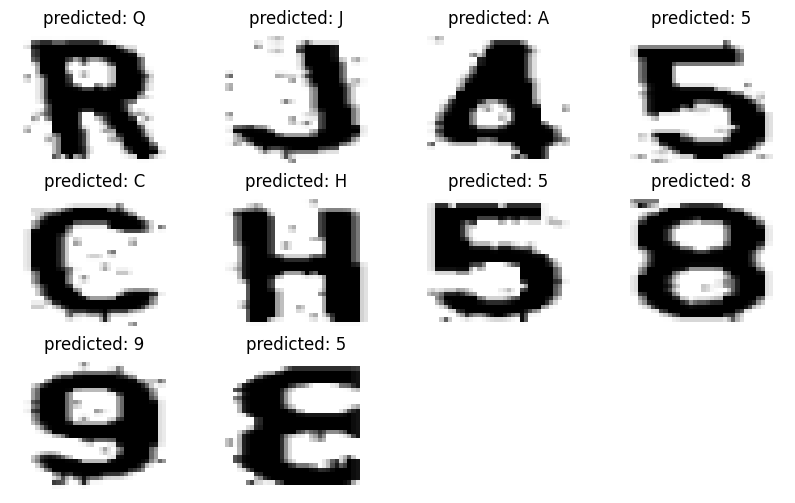

In [93]:
plt.figure(figsize=(10,6))
for i,ch in enumerate(char):
    img = cv2.resize(ch, (40,32), interpolation=cv2.INTER_AREA)
    plt.subplot(3,4,i+1)
    plt.imshow(img,cmap='gray')
    plt.title(f'predicted: {show_results()[i]}')
    plt.axis('off')
plt.show()

In [ ]:
def read_first_column(csv_file_path):
    column_items = []
    with open(csv_file_path, 'r') as file:
        csv_reader = csv.reader(file)
        for row in csv_reader:
            # Check if the row has at least one element before accessing the first column
            if row:
                column_items.append(row[0])
            else:
                column_items.append("")  # If the row is empty, append an empty string
    return column_items